# 实验3程序 (Lab3 Program)

Author: 高鹏昺

Email: nbgao@126.com

In [690]:
import numpy as np
import sklearn
import scipy.io as sio
from scipy import ndimage
import matplotlib.pyplot as plt
from skimage import feature as feature
from sklearn.metrics import classification_report
import time
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [691]:
# mnist = fetch_mldata('mnist-original', data_home = './data/') 
mnist = sio.loadmat('./data/mnist-original.mat')
mnist

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar 30 03:19:02 2014',
 '__version__': '1.0',
 '__globals__': [],
 'mldata_descr_ordering': array([[array(['label'], dtype='<U5'), array(['data'], dtype='<U4')]],
       dtype=object),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'label': array([[0., 0., 0., ..., 9., 9., 9.]])}

In [788]:
data, label = mnist['data'].T, mnist['label'].T.astype('int')

print('data shape:', data.shape)
print('label shape:', label.shape)

data shape: (70000, 784)
label shape: (70000, 1)


In [6]:
img = np.zeros([len(data), 28, 28])
for i in range(0,len(data)):
    img[i] = data[i].reshape(28, 28)

(-0.5, 27.5, 27.5, -0.5)

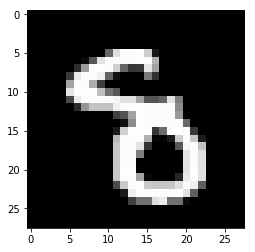

In [7]:
plt.imshow(img[50000], cmap='gray')
plt.axis()

In [774]:
index_list = range(data.shape[0])
random_index = random.sample(index_list, 10000)

In [789]:
data_sub = data[random_index]
label_sub = label[random_index]
print(data_sub.shape)
print(label_sub.shape)

(10000, 784)
(10000, 1)


# 1. Naive Bayes

## 1.1 Source Code

In [864]:
# 图像二值化 
data_bin = data.copy()
threshold = 128
M, N = data_bin.shape
for i in range(M):
    for j in range(N):
        data_bin[i,j] = 1 if data_bin[i,j]>=threshold else 0

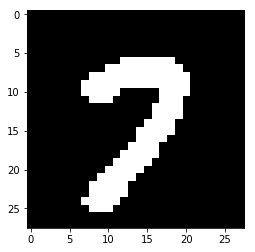

In [770]:
# 二值化后的图像
plt.imshow(data_bin[0].reshape(28,28), cmap='gray')

In [870]:
from sklearn.model_selection import train_test_split

data_train, data_test, label_train, label_test = train_test_split(data_bin, label, test_size=1/7, random_state=33)
print('data_train.shape:', data_train.shape)
print('data_test.shape:', data_test.shape)

data_train.shape: (60000, 784)
data_test.shape: (10000, 784)


In [871]:
class NaiveBayes():
    def Train(self, X, Y):
        M, N = X.shape
        Y = Y[:,0]
        class_num = 10
        self.P_prior = np.zeros(class_num)         # 先验概率
        self.P_con = np.zeros((class_num, N, 2))   # 条件概率

        # 计算先验概率及条件概率
        for i in range(M):
            img = X[i]
            y = Y[i]
            self.P_prior[y] += 1
            for j in range(N):
                self.P_con[y][j][img[j]] += 1

        # 将概率归到[1.10001]
        for i in range(class_num):
            for j in range(N):
                pix_0 = self.P_con[i][j][0]
                pix_1 = self.P_con[i][j][1]

                # 计算0，1像素点对应的条件概率
                P_0 = (float(pix_0)/float(pix_0+pix_1))*1000000 + 1
                P_1 = (float(pix_1)/float(pix_0+pix_1))*1000000 + 1

                self.P_con[i][j][0] = P_0
                self.P_con[i][j][1] = P_1

        return self.P_prior, self.P_con

    # 计算概率
    def calc_P(self, img, y):
        prob = int(self.P_prior[y])

        for i in range(len(img)):
            prob *= int(self.P_con[y][i][img[i]])

        return prob

    def Predict(self, X_test):
        predict = []
        class_num = 10
        for img in X_test:
            max_y = 0
            max_prob = 0
    #         max_prob = calc_P(img, 0)
            for j in range(class_num):
                prob = self.calc_P(img, j)
                if prob > max_prob:
                    max_y = j
                    max_prob = prob

            predict.append(max_y)

        return np.array(predict)

In [872]:
# 模型训练
model = NaiveBayes()
model.Train(data_train, label_train);

In [873]:
# 模型预测
label_predict = model.Predict(data_test)
label_predict

array([9, 8, 6, ..., 8, 2, 8])

In [874]:
print(classification_report(label_test, label_predict))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       957
           1       0.88      0.96      0.92      1113
           2       0.88      0.83      0.85      1040
           3       0.77      0.81      0.79      1012
           4       0.81      0.79      0.80       949
           5       0.81      0.71      0.76       940
           6       0.90      0.92      0.91      1006
           7       0.93      0.85      0.89      1014
           8       0.74      0.78      0.76       970
           9       0.74      0.82      0.78       999

   micro avg       0.84      0.84      0.84     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.84      0.84     10000



## 1.2 Naive Bayes - sklearn

### Gaussian Naive Bayes

In [876]:
import sklearn.naive_bayes as naive_bayes

model = naive_bayes.GaussianNB()
model.fit(data_train, label_train)
label_predict = model.predict(data_test)

In [877]:
# Result Evaluation
print('The Accuracy of Naive Bayes:', model.score(data_test, label_test))
print(classification_report(label_test, label_predict))

The Accuracy of Naive Bayes: 0.5506
              precision    recall  f1-score   support

           0       0.60      0.94      0.74       957
           1       0.68      0.97      0.80      1113
           2       0.85      0.23      0.36      1040
           3       0.71      0.45      0.55      1012
           4       0.87      0.14      0.25       949
           5       0.69      0.04      0.07       940
           6       0.66      0.93      0.77      1006
           7       0.90      0.29      0.44      1014
           8       0.32      0.51      0.39       970
           9       0.37      0.93      0.53       999

   micro avg       0.55      0.55      0.55     10000
   macro avg       0.66      0.54      0.49     10000
weighted avg       0.67      0.55      0.50     10000



### Bernoulli Naive Bayes

In [878]:
model = naive_bayes.BernoulliNB()
model.fit(data_train, label_train)
label_predict = model.predict(data_test)

In [879]:
# Result Evaluation
print('The Accuracy of Naive Bayes:', model.score(data_test, label_test))
print(classification_report(label_test, label_predict))

The Accuracy of Naive Bayes: 0.8351
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       957
           1       0.88      0.96      0.92      1113
           2       0.88      0.83      0.85      1040
           3       0.77      0.80      0.78      1012
           4       0.80      0.79      0.79       949
           5       0.81      0.71      0.76       940
           6       0.90      0.92      0.91      1006
           7       0.93      0.84      0.89      1014
           8       0.74      0.78      0.76       970
           9       0.74      0.81      0.77       999

   micro avg       0.84      0.84      0.84     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.84      0.84     10000



# 2. K-Means

## 2.1 K-Means Source Code

In [596]:
time_start = time.time()
### K = 10 设置0个数聚类类别
K = 10
print('Init clusters num:', num)
# 初始化聚类中心 C K*N 10*784
C = np.floor(256*np.random.random((K, N)))

iter = 0
maxIter = 1000
while iter<maxIter:
    # 距离矩阵 D M*K 10000*10
    D = np.zeros((M, K))
    for k in range(K):
        for i in range(M):
            D[i,k] = np.sqrt(np.sum(np.square(data_sub[i,:] - C[k,:])))
            # D[i,k] = np.linalg.norm(data_sub[i,:]-C[k,:])
    y = np.argmin(D, axis=1)
    num = np.unique(y).size
    # 初始化必须为10类
    if num!=K:
        C = np.floor(256*np.random.random((K, N)))
        continue

    for k in range(K):
        C[k,:] = np.mean(data_sub[y==k,:], axis=0).astype('int') 
        
    if iter%50==0:
        print('Iter: ', iter)
    iter += 1

time_end = time.time()
print('Finished: {:.1f} s'.format(time_end-time_start))

Init clusters num: 10
Iter:  0
Iter:  50
Iter:  100
Iter:  150
Iter:  200
Iter:  250
Iter:  300
Iter:  350
Iter:  400
Iter:  450
Iter:  500
Iter:  550
Iter:  600
Iter:  650
Iter:  700
Iter:  750
Iter:  800
Iter:  850
Iter:  900
Iter:  950
Finished: 955.0 s


### Result
初始中心点的选取对K-Means的聚类效果有很大的影响

In [704]:
# 聚类后每一类别的数量
for i in range(10):
    print('第{}类别样本数: {}'.format(i, data_sub[y==i].shape[0]))

第0类别样本数: 726
第1类别样本数: 1060
第2类别样本数: 883
第3类别样本数: 1218
第4类别样本数: 688
第5类别样本数: 891
第6类别样本数: 1365
第7类别样本数: 1603
第8类别样本数: 781
第9类别样本数: 785


第0类中心图像:


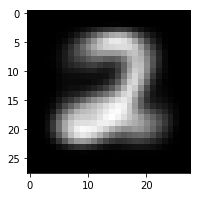

第1类中心图像:


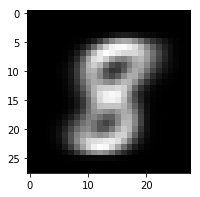

第2类中心图像:


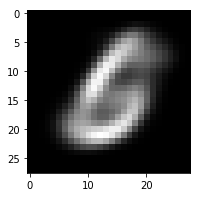

第3类中心图像:


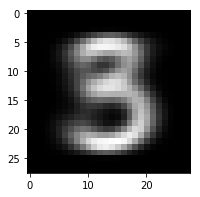

第4类中心图像:


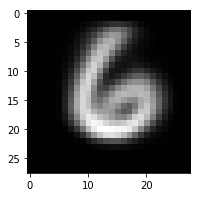

第5类中心图像:


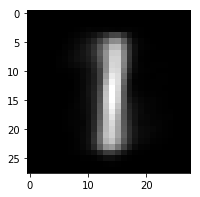

第6类中心图像:


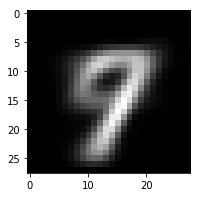

第7类中心图像:


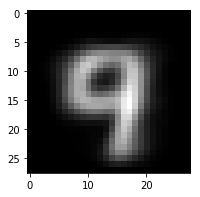

第8类中心图像:


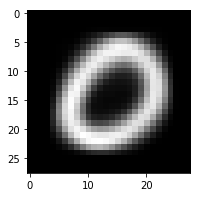

第9类中心图像:


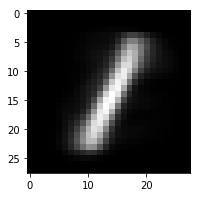

In [883]:
for k in range(K):
    print('第%d类中心图像:' % k)
    img_C = C[k].reshape(28,28)
    plt.figure(figsize=(3,3))
    plt.imshow(img_C, cmap='gray')
    plt.pause(0.1)

## 3.2 K-Means - sklearn

In [692]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0).fit(data_sub)

In [694]:
kmeans.labels_

array([5, 9, 9, ..., 7, 7, 1], dtype=int32)

In [703]:
for i in range(10):
    print('第{}类别样本数: {}'.format(i, np.sum(kmeans.labels_==i)))

第0类别样本数: 875
第1类别样本数: 834
第2类别样本数: 1056
第3类别样本数: 1231
第4类别样本数: 849
第5类别样本数: 1098
第6类别样本数: 900
第7类别样本数: 1310
第8类别样本数: 1103
第9类别样本数: 744


# 3. PCA

## 3.1 PCA 传统算法

In [721]:
def PCA(X, k):
    # 按列取均值
    X_mean = np.mean(X, axis=0)
    X_ = X - X_mean
    # 协方差矩阵 rowvar=0 
    X_cov = np.cov(X_, rowvar=0)
    # 特征值和特征向量
    eigVal, eigVec = np.linalg.eig(np.mat(X_cov))
    #对特征值从小到大排序
    eigValIndex = np.argsort(eigVal)
    #最大的k个特征值的下标
    k_eigValIndex = eigValIndex[-1:-(k+1):-1]
    #最大的n个特征值对应的特征向量
    k_eigVec = eigVec[:, k_eigValIndex]
    #低维特征空间的数据
    X_k = X_ * k_eigVec
    #重构数据
    reMat = (X_k * k_eigVec.T) + X_mean
    return X_k, reMat


In [725]:
X_k, reMat = PCA(data_sub, 50)

In [726]:
print(X_k.shape)
print(reMat.shape)

(10000, 50)
(10000, 784)


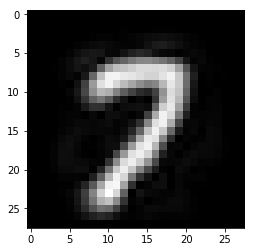

In [727]:
img = np.abs(reMat[0]).reshape(28,28).astype('int')
plt.imshow(img, cmap='gray')

## 3.2 PCA 奇异值分解(SVD)算法

In [896]:
def PCA_SVD(X, k):
    covMat = np.dot(X.T, X)/(M-1)
    u, s, v = np.linalg.svd(covMat)
    T = np.dot(X, u[:,:k])
    return T

In [899]:
T = PCA_SVD(X, 50)
print(T.shape)
print(T)

(10000, 50)
[[-1329.31948708  -959.99227588  -224.50817685 ...   -28.68170597
    -81.19459051   -63.30501967]
 [-1540.46941127  -987.13012311   339.84759829 ...   -18.18815184
     38.00382176   -96.65552521]
 [-1715.22502278 -1065.26519304    66.9821054  ...  -178.54200098
      4.90638137   -48.43169325]
 ...
 [ -851.40327334  -426.1562264    -24.18855936 ...   -55.29607366
     11.82020514   114.23041455]
 [-1074.37563658  -746.59868557  -128.69716244 ...  -140.00759267
    -30.91472762   104.99387577]
 [ -630.03165651  -477.30607689  -110.97856827 ...    85.22725814
    -48.24014894    33.73669229]]


## 3.3 PCA - sklearn

In [728]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca.fit(data_sub)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [729]:
data_pca = pca.transform(data_sub)

In [730]:
data_pca.shape

(10000, 50)

In [733]:
# 降维后数据
data_pca

array([[-190.54010314,  459.9319017 ,  304.90645843, ...,  -23.70200636,
          92.8111602 ,   63.70358041],
       [ -18.27880804, -654.43739189,   99.76250137, ...,  225.62510015,
        -238.68303954,  140.97987998],
       [ 516.74242783, -336.64436086, -147.76317854, ...,   89.95069988,
          55.80726722,  -76.03606265],
       ...,
       [  23.37445859, -315.50668318, -758.9711646 , ...,  166.57956989,
        -281.35975586, -149.48653242],
       [-327.97222304, -311.49719017, -769.1314679 , ...,  288.16626196,
          97.95921343, -100.87810799],
       [-740.4646048 ,  -16.40734487,  114.86595541, ...,   80.02984126,
         -98.66584748,  123.85997183]])

In [734]:
# 奇异值
pca.singular_values_

array([58253.86132849, 49583.36186426, 46090.84040784, 42639.39450517,
       40871.18001335, 38527.06805146, 33480.46406549, 31865.33639714,
       30632.01776809, 28415.08980791, 26918.88186538, 26884.6981031 ,
       24323.84369735, 23878.7738796 , 23203.93526359, 22677.09370429,
       21143.32243123, 20853.27897319, 20239.92608643, 19905.07452929,
       19319.53419022, 18665.29530365, 18123.30929843, 17701.13511086,
       17577.42686699, 16981.33332399, 16612.96806322, 16511.67616122,
       15910.09204394, 15282.81230599, 15067.5526391 , 14848.89591282,
       14362.40974541, 14054.22792841, 13772.52646269, 13631.65610507,
       13136.07278111, 12941.06688365, 12821.27133458, 12528.21699841,
       12412.56815472, 12293.19728099, 11866.3063275 , 11599.58183068,
       11555.53440319, 11340.02821113, 11059.46772604, 11008.08875833,
       10802.9282149 , 10476.50514522])